# **DATA UNDERSTANDING & EDA**

In [1]:
import numpy as np
import pandas as pd
print(np.__version__)
print(pd.__version__)

1.26.4
2.3.3


In [2]:
tcs = pd.read_csv("TCS.csv")
tcs

,Date,Close,High,Low,Open,Volume
0,01-01-2015,1006.856506,1015.340733,1005.056799,1015.340733,366830
1,02-01-2015,1020.265137,1024.813800,1008.853983,1009.012159,925740
2,05-01-2015,1004.760376,1028.354061,998.589975,1020.878469,1754242
3,06-01-2015,967.718262,1000.349977,965.107686,1000.349977,2423784
4,07-01-2015,956.287293,980.592959,952.233049,976.973843,2636332
...,...,...,...,...,...,...
2712,24-12-2025,3319.000000,3327.100098,3296.100098,3304.100098,1367708
2713,25-12-2025,3319.000000,3319.000000,3319.000000,3319.000000,0
2714,26-12-2025,3280.000000,3320.000000,3271.800049,3313.100098,1176664
2715,29-12-2025,3251.500000,3288.000000,3242.899902,3280.000000,2079473


In [3]:
tcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2717 non-null   object 
 1   Close   2717 non-null   float64
 2   High    2717 non-null   float64
 3   Low     2717 non-null   float64
 4   Open    2717 non-null   float64
 5   Volume  2717 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 127.5+ KB


In [4]:
weekly_return = (tcs["Close"].shift(-5) / tcs["Close"]) - 1
tcs["target"] = (weekly_return > 0).astype(int)


In [5]:
tcs['Date'] = pd.to_datetime(tcs['Date'],format= '%d-%m-%Y')
tcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2717 non-null   datetime64[ns]
 1   Close   2717 non-null   float64       
 2   High    2717 non-null   float64       
 3   Low     2717 non-null   float64       
 4   Open    2717 non-null   float64       
 5   Volume  2717 non-null   int64         
 6   target  2717 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1)
memory usage: 138.1 KB


In [6]:
tcs['5_day_ret'] = (tcs['Close']/tcs['Close'].shift(5))-1
tcs['20_day_ret'] = (tcs['Close']/tcs['Close'].shift(20))-1
tcs['60_day_ret'] = (tcs['Close']/tcs['Close'].shift(60))-1


In [7]:
def simple_moving_average(series, window):
    return series.rolling(window=window, min_periods=window).mean()
sma20= simple_moving_average(tcs['Close'], 20)
tcs['dma_20'] = (tcs['Close'] - sma20)/sma20



In [8]:
ret = tcs['Close'].pct_change()
tcs['roll_std_10'] = ret.rolling(10).std()
tcs['roll_std_20'] = ret.rolling(20).std()



In [9]:
high_low = tcs['High'] - tcs['Low']
high_close = np.abs(tcs['High'] - tcs['Close'].shift(1))
low_close = np.abs(tcs['Low'] - tcs['Close'].shift(1))

tcs['TR'] = np.maximum.reduce([high_low, high_close, low_close])
tcs['ATR'] = tcs['TR'].rolling(window=14).mean()
tcs = tcs.drop("TR",axis=1)


In [10]:
tcs['vol_change_5'] = (tcs['Volume']/tcs['Volume'].shift(5))-1

In [11]:
avg_vol_20 = tcs['Volume'].rolling(window=20).mean()
tcs['vol_ratio'] = tcs['Volume']/avg_vol_20

In [12]:
delta = tcs['Close'].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)

window = 14
avg_gain = gain.ewm(alpha = 1/window,adjust = False).mean()
avg_loss = loss.ewm(alpha = 1/window,adjust = False).mean()
RS = avg_gain/avg_loss
tcs['RSI_14'] = 100 - (100/1+RS)

In [13]:
ema12 = tcs['Close'].ewm(span = 12,adjust = False).mean()
ema26 = tcs['Close'].ewm(span = 26,adjust = False).mean()
ema9 = tcs['Close'].ewm(span = 9,adjust = False).mean()
macd = ema12 - ema26
signal = ema9 * macd
tcs['macd_histogram'] = macd - signal

In [14]:
high_diff = tcs['High'].diff()
low_diff  = -tcs['Low'].diff()

plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0.0)
minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0.0)

tr = np.maximum.reduce([
    tcs['High'] - tcs['Low'],
    np.abs(tcs['High'] - tcs['Close'].shift(1)),
    np.abs(tcs['Low'] - tcs['Close'].shift(1))
])

window = 14

tr_smoothed = pd.Series(tr).ewm(alpha=1/window, adjust=False).mean()
plus_dm_smoothed = pd.Series(plus_dm).ewm(alpha=1/window, adjust=False).mean()
minus_dm_smoothed = pd.Series(minus_dm).ewm(alpha=1/window, adjust=False).mean()

plus_di_14 = 100 * (plus_dm_smoothed / tr_smoothed)
minus_di_14 = 100 * (minus_dm_smoothed / tr_smoothed)

dx = 100 * (
    np.abs(plus_di_14 - minus_di_14) /
    (plus_di_14 + minus_di_14)
)

tcs['adx_14'] = dx.ewm(alpha=1/window, adjust=False).mean()

In [15]:
tcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            2717 non-null   datetime64[ns]
 1   Close           2717 non-null   float64       
 2   High            2717 non-null   float64       
 3   Low             2717 non-null   float64       
 4   Open            2717 non-null   float64       
 5   Volume          2717 non-null   int64         
 6   target          2717 non-null   int32         
 7   5_day_ret       2712 non-null   float64       
 8   20_day_ret      2697 non-null   float64       
 9   60_day_ret      2657 non-null   float64       
 10  dma_20          2698 non-null   float64       
 11  roll_std_10     2707 non-null   float64       
 12  roll_std_20     2697 non-null   float64       
 13  ATR             2703 non-null   float64       
 14  vol_change_5    2712 non-null   float64       
 15  vol_

In [16]:
tcs['day'] = tcs['Date'].dt.day_name()
tcs['day_idx'] = tcs['Date'].dt.weekday


In [17]:
tcs_weekly_df = tcs[tcs['day_idx']==4]
tcs_weekly_df = tcs_weekly_df.drop(['day','day_idx','High','Low','Open','Close','Volume'],axis = 1)


In [18]:
tcs_weekly_df.shape

(535, 14)

In [19]:
tcs_weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 535 entries, 1 to 2714
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            535 non-null    datetime64[ns]
 1   target          535 non-null    int32         
 2   5_day_ret       534 non-null    float64       
 3   20_day_ret      531 non-null    float64       
 4   60_day_ret      523 non-null    float64       
 5   dma_20          531 non-null    float64       
 6   roll_std_10     533 non-null    float64       
 7   roll_std_20     531 non-null    float64       
 8   ATR             532 non-null    float64       
 9   vol_change_5    534 non-null    float64       
 10  vol_ratio       531 non-null    float64       
 11  RSI_14          535 non-null    float64       
 12  macd_histogram  535 non-null    float64       
 13  adx_14          535 non-null    float64       
dtypes: datetime64[ns](1), float64(12), int32(1)
memory usage: 60.6

In [20]:
tcs_weekly_df.isnull().sum()

Date               0
target             0
5_day_ret          1
20_day_ret         4
60_day_ret        12
dma_20             4
roll_std_10        2
roll_std_20        4
ATR                3
vol_change_5       1
vol_ratio          4
RSI_14             0
macd_histogram     0
adx_14             0
dtype: int64

In [21]:
tcs_weekly_df.duplicated().sum()

0

# **FEATURE ENGINEERING**

In [22]:
def create_features(df,name):
    df = df.copy()
    
    df['Stock'] = name
    df['weekly_return'] = (df["Close"].shift(-5) / df["Close"]) - 1
    df["target"] = (df['weekly_return'] > 0).astype(int)
    df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y')

    df['5_day_ret'] = (df['Close']/df['Close'].shift(5))-1
    df['20_day_ret'] = (df['Close']/df['Close'].shift(20))-1
    df['60_day_ret'] = (df['Close']/df['Close'].shift(60))-1

    def simple_moving_average(series, window):
        return series.rolling(window=window, min_periods=window).mean()
    sma20= simple_moving_average(tcs['Close'], 20)
    df['dma_20'] = (df['Close'] - sma20)/sma20

    ret = df['Close'].pct_change()
    df['roll_std_10'] = ret.rolling(10).std()
    df['roll_std_20'] = ret.rolling(20).std()

    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))

    df['TR'] = np.maximum.reduce([high_low, high_close, low_close])
    df['ATR'] = df['TR'].rolling(window=14).mean()
    df = df.drop("TR",axis=1)

    df['vol_change_5'] = (df['Volume']/df['Volume'].shift(5))-1

    avg_vol_20 = tcs['Volume'].rolling(window=20).mean()
    df['vol_ratio'] = df['Volume']/avg_vol_20
    
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    window = 14
    avg_gain = gain.ewm(alpha = 1/window,adjust = False).mean()
    avg_loss = loss.ewm(alpha = 1/window,adjust = False).mean()
    RS = avg_gain/avg_loss
    df['RSI_14'] = 100 - (100/1+RS)

    ema12 = df['Close'].ewm(span = 12,adjust = False).mean()
    ema26 = df['Close'].ewm(span = 26,adjust = False).mean()
    ema9 = df['Close'].ewm(span = 9,adjust = False).mean()
    macd = ema12 - ema26
    signal = ema9 * macd
    df['macd_histogram'] = macd - signal

    high_diff = df['High'].diff()
    low_diff  = -df['Low'].diff()
    
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0.0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0.0)
    
    tr = np.maximum.reduce([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift(1)),
        np.abs(df['Low'] - df['Close'].shift(1))
    ])
    
    window = 14
    
    tr_smoothed = pd.Series(tr).ewm(alpha=1/window, adjust=False).mean()
    plus_dm_smoothed = pd.Series(plus_dm).ewm(alpha=1/window, adjust=False).mean()
    minus_dm_smoothed = pd.Series(minus_dm).ewm(alpha=1/window, adjust=False).mean()
    
    plus_di_14 = 100 * (plus_dm_smoothed / tr_smoothed)
    minus_di_14 = 100 * (minus_dm_smoothed / tr_smoothed)
    
    dx = 100 * (
        np.abs(plus_di_14 - minus_di_14) /
        (plus_di_14 + minus_di_14)
    )
    
    df['adx_14'] = dx.ewm(alpha=1/window, adjust=False).mean()

    df['day_idx'] = df['Date'].dt.weekday

    weekly_df = df[df['day_idx']==4]
    weekly_df = weekly_df.drop(['day_idx','High','Low','Open','Close','Volume'],axis = 1)

    return weekly_df
    

In [23]:
BAJFINANCE = pd.read_csv("BAJFINANCE.csv")
BHARTIARTL = pd.read_csv("BHARTIARTL.csv")
HCLTECH = pd.read_csv("HCLTECH.csv")
HDFCBANK = pd.read_csv("HDFCBANK.csv")
HINDUNILVR = pd.read_csv("HINDUNILVR.csv")
ICICIBANK = pd.read_csv("ICICIBANK.csv")
INFY = pd.read_csv("INFY.csv")
MARUTI = pd.read_csv("MARUTI.csv")
RELIANCE = pd.read_csv("RELIANCE.csv")
TCS = pd.read_csv("TCS.csv")



In [24]:
BAJFINANCE_weekly = create_features(BAJFINANCE,'BAJFINANCE')
BHARTIARTL_weekly = create_features(BHARTIARTL,'BHARTIARTL')
HCLTECH_weekly = create_features(HCLTECH,'HCLTECH')
HDFCBANK_weekly =create_features(HDFCBANK,'HDFCBANK')
HINDUNILVR_weekly = create_features(HINDUNILVR,'HINDUNILVR')
ICICIBANK_weekly =create_features(ICICIBANK,'ICICIBANK')
INFY_weekly = create_features(INFY,'INFY')
MARUTI_weekly = create_features(MARUTI,'MARUTI')
RELIANCE_weekly = create_features(RELIANCE,'RELIANCE')
TCS_weekly = create_features(TCS,'TCS')

In [25]:
weekly_df = pd.concat([BAJFINANCE_weekly,
                       BHARTIARTL_weekly,
                       HCLTECH_weekly,
                       HDFCBANK_weekly,
                       HINDUNILVR_weekly,
                       ICICIBANK_weekly,
                       INFY_weekly,
                       MARUTI_weekly,
                       RELIANCE_weekly,
                       TCS_weekly],axis = 0, join ='inner')

In [26]:
weekly_df.shape

(5350, 16)

In [27]:
weekly_df = weekly_df.sort_values(by=['Date','Stock']).reset_index (drop = True)
weekly_df.head(11)

,Date,Stock,weekly_return,target,5_day_ret,20_day_ret,60_day_ret,dma_20,roll_std_10,roll_std_20,ATR,vol_change_5,vol_ratio,RSI_14,macd_histogram,adx_14
0,2015-01-02,BAJFINANCE,0.001829,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.405677,100.000000
1,2015-01-02,BHARTIARTL,-0.025339,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-44.761450,100.000000
2,2015-01-02,HCLTECH,-0.037190,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,6.835354,100.000000
3,2015-01-02,HDFCBANK,0.010722,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-52.296899,100.000000
4,2015-01-02,HINDUNILVR,0.143726,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,105.175977,100.000000
5,2015-01-02,ICICIBANK,-0.056445,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-196.195961,100.000000
6,2015-01-02,INFY,0.030424,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-212.288265,100.000000
7,2015-01-02,MARUTI,0.032325,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-4141.283748,100.000000
8,2015-01-02,RELIANCE,-0.028513,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,7.577671,100.000000
9,2015-01-02,TCS,-0.026033,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,inf,-1078.767168,100.000000


In [28]:
weekly_df = weekly_df.replace([np.inf,-np.inf],np.nan)
weekly_df.isnull().sum()

Date                0
Stock               0
weekly_return      10
target              0
5_day_ret          10
20_day_ret         40
60_day_ret        120
dma_20             40
roll_std_10        20
roll_std_20        40
ATR                30
vol_change_5       10
vol_ratio          40
RSI_14              6
macd_histogram      0
adx_14              0
dtype: int64

In [29]:
weekly_df.shape

(5350, 16)

In [30]:
weekly_df.duplicated().sum()

0

In [31]:
weekly_df.sample()

,Date,Stock,weekly_return,target,5_day_ret,20_day_ret,60_day_ret,dma_20,roll_std_10,roll_std_20,ATR,vol_change_5,vol_ratio,RSI_14,macd_histogram,adx_14
1637,2018-06-01,MARUTI,0.014031,1,0.030498,0.015055,0.022323,4.593213,0.015824,0.012587,156.898974,0.930094,0.34747,-1.205813,434737.052869,23.188591


In [32]:
X = weekly_df.drop(columns=["Date", "target","weekly_return","Stock"])
y = weekly_df["target"].values
dates = weekly_df["Date"]

train_end_date = "2022-12-31"
test_start_date = "2023-01-01"

train_mask = (dates <= train_end_date)
test_mask  = (dates >= test_start_date)

X_train = X[train_mask].values
y_train = y[train_mask]

X_test  = X[test_mask].values
y_test  = y[test_mask]

print(dates[train_mask].max())
print(dates[test_mask].min())


2022-12-30 00:00:00
2023-01-06 00:00:00


In [33]:
from sklearn.impute import KNNImputer

In [34]:
knn = KNNImputer(n_neighbors=3,weights='distance')
X_train_trf = knn.fit_transform(X_train)
X_test_trf = knn.transform(X_test)

In [35]:
X_train_df = pd.DataFrame(X_train_trf,columns = X.columns)
X_test_df = pd.DataFrame(X_test_trf,columns = X.columns)

In [36]:
X_train_df.sample(6)

,5_day_ret,20_day_ret,60_day_ret,dma_20,roll_std_10,roll_std_20,ATR,vol_change_5,vol_ratio,RSI_14,macd_histogram,adx_14
3191,0.024348,0.074620,0.003036,-0.814190,0.024370,0.018293,14.222342,-0.695025,4.670439,-1.607375,-3602.728346,25.027868
1880,0.065589,0.065119,-0.132929,-0.846362,0.019121,0.018695,7.060611,0.706275,10.382838,-1.753694,-923.649939,17.135727
1855,0.122921,0.119905,0.192543,-0.791365,0.037311,0.031591,12.560021,0.163917,8.873458,-1.904512,-2808.285631,31.396709
1402,-0.033085,-0.020244,-0.022450,-0.706056,0.009517,0.012916,6.144673,0.681199,1.465519,-0.576049,1056.102125,19.609585
2926,0.025036,0.160240,0.183784,-0.560251,0.023461,0.019790,29.503316,0.138947,3.675631,-1.939364,-54405.194065,35.555753
2811,0.081539,0.036012,-0.211218,-0.825502,0.021629,0.022133,12.653119,-0.221725,2.726542,-0.963457,5755.258724,36.701563


In [37]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

robust_cols = [
    "5_day_ret",
    "20_day_ret",
    "60_day_ret",
    "dma_20",
    "roll_std_10",
    "roll_std_20",
    "vol_change_5",
    "ATR",
    "vol_ratio"
]

standard_cols = [
    "RSI_14",
    "adx_14"
]

macd_col = ["macd_histogram"]

def signed_log1p(x):
    return np.sign(x) * np.log1p(np.abs(x))

macd_scaler = Pipeline([
    ("log", FunctionTransformer(signed_log1p)),
    ("scaler", RobustScaler())
])

scaler = ColumnTransformer(
    transformers=[
        ("robust", RobustScaler(), robust_cols),
        ("standard", StandardScaler(), standard_cols),
        ("macd", macd_scaler, macd_col)
    ],
    remainder="drop"
)


In [38]:
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled  = scaler.transform(X_test_df)


In [39]:
X_train_scaled

array([[ 0.7001326 ,  0.05130966,  0.06882147, ...,  1.12769307,
         6.19809504,  0.47454523],
       [ 1.31549054,  1.31704633,  1.11093328, ..., -1.97499084,
         6.19809504,  0.18196099],
       [ 0.65124503, -0.28161555,  0.06350951, ...,  1.12769307,
         6.19809504,  0.54803335],
       ...,
       [ 0.64868086, -0.67868092, -0.49324184, ...,  0.54255385,
         0.8986129 ,  1.28643827],
       [ 0.34599509, -0.85600773,  0.06347463, ...,  0.47316404,
        -0.45753568,  0.99287109],
       [ 0.13321427, -0.73534117,  0.06816702, ...,  0.40554041,
        -0.5006733 ,  1.0843547 ]])

In [40]:
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns = X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns = X.columns)

In [41]:
X_train_scaled_df.shape

(3880, 12)

In [42]:
X_test_scaled_df.shape

(1470, 12)

In [43]:
X_train_scaled_df

,5_day_ret,20_day_ret,60_day_ret,dma_20,roll_std_10,roll_std_20,ATR,vol_change_5,vol_ratio,RSI_14,macd_histogram,adx_14
0,0.700133,0.051310,0.068821,-0.483043,1.705185,0.898435,0.731826,-0.662560,-0.252195,1.127693,6.198095,0.474545
1,1.315491,1.317046,1.110933,-0.495537,1.904768,1.971369,2.166806,-0.656999,-0.235716,-1.974991,6.198095,0.181961
2,0.651245,-0.281616,0.063510,-0.471319,1.710130,0.859949,0.701742,-0.662002,-0.157474,1.127693,6.198095,0.548033
3,1.255166,1.327497,1.021132,-0.495562,1.943426,1.979651,2.302415,-0.655924,-0.228912,-1.817782,6.198095,0.172474
4,0.694332,-0.024112,-0.132459,-0.050658,0.421620,-0.042758,17.221028,-0.393568,2.174615,1.127693,6.198095,0.710246
...,...,...,...,...,...,...,...,...,...,...,...,...
3875,0.244543,-0.624159,-0.115449,-0.061912,-0.233399,-0.654028,-0.122949,0.119575,1.161734,0.519443,-0.304741,0.958968
3876,0.101603,-1.016471,0.132654,0.235214,-0.758443,-0.375295,-0.207657,0.513403,0.334992,0.533453,0.083063,1.045113
3877,0.648681,-0.678681,-0.493242,4.147920,-0.070753,-0.640376,-0.138883,6.744743,-0.491497,0.542554,0.898613,1.286438
3878,0.345995,-0.856008,0.063475,0.107766,-0.184418,-0.579787,-0.321016,0.296972,0.733168,0.473164,-0.457536,0.992871


In [44]:
y_test_df = pd.DataFrame(y_test)


In [45]:
y_test_df.value_counts()

0
1    786
0    684
Name: count, dtype: int64

In [46]:
y_train_df = pd.DataFrame(y_train)
y_train_df.value_counts()

0
1    2110
0    1770
Name: count, dtype: int64

In [47]:
X_train_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5_day_ret       3880 non-null   float64
 1   20_day_ret      3880 non-null   float64
 2   60_day_ret      3880 non-null   float64
 3   dma_20          3880 non-null   float64
 4   roll_std_10     3880 non-null   float64
 5   roll_std_20     3880 non-null   float64
 6   ATR             3880 non-null   float64
 7   vol_change_5    3880 non-null   float64
 8   vol_ratio       3880 non-null   float64
 9   RSI_14          3880 non-null   float64
 10  macd_histogram  3880 non-null   float64
 11  adx_14          3880 non-null   float64
dtypes: float64(12)
memory usage: 363.9 KB


In [48]:
X_test_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5_day_ret       1470 non-null   float64
 1   20_day_ret      1470 non-null   float64
 2   60_day_ret      1470 non-null   float64
 3   dma_20          1470 non-null   float64
 4   roll_std_10     1470 non-null   float64
 5   roll_std_20     1470 non-null   float64
 6   ATR             1470 non-null   float64
 7   vol_change_5    1470 non-null   float64
 8   vol_ratio       1470 non-null   float64
 9   RSI_14          1470 non-null   float64
 10  macd_histogram  1470 non-null   float64
 11  adx_14          1470 non-null   float64
dtypes: float64(12)
memory usage: 137.9 KB


In [49]:
y_train=y_train.astype(np.float64)

In [50]:
y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3880 non-null   int32
dtypes: int32(1)
memory usage: 15.3 KB


In [51]:
X_train_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   5_day_ret       3880 non-null   float64
 1   20_day_ret      3880 non-null   float64
 2   60_day_ret      3880 non-null   float64
 3   dma_20          3880 non-null   float64
 4   roll_std_10     3880 non-null   float64
 5   roll_std_20     3880 non-null   float64
 6   ATR             3880 non-null   float64
 7   vol_change_5    3880 non-null   float64
 8   vol_ratio       3880 non-null   float64
 9   RSI_14          3880 non-null   float64
 10  macd_histogram  3880 non-null   float64
 11  adx_14          3880 non-null   float64
dtypes: float64(12)
memory usage: 363.9 KB


In [52]:
split_idx = int(0.8 * len(X_train_scaled))

X_tr = X_train_scaled[:split_idx]
y_tr = y_train[:split_idx]

X_val = X_train_scaled[split_idx:]
y_val = y_train[split_idx:]


# **MODEL BUILDING**

## **USING ANN**

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam


In [54]:
ANN = Sequential([
        Input(shape=(12,)),
        Dense(24,activation='relu'),
        Dropout(0.1),
        Dense(36,activation='relu'),
        Dropout(0.3),
        Dense(24,activation='relu'),
        Dropout(0.1),
        Dense(12,activation='relu'),
        Dense(1,activation = 'sigmoid')
    ])


In [55]:
metrics = [
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.MeanAbsoluteError(name='mae'),
    tf.keras.metrics.RootMeanSquaredError(name='rmse')
]

ANN.compile(
   optimizer=Adam(learning_rate=0.001),
   loss='binary_crossentropy',
   metrics=metrics
)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_weight.weights.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)


In [57]:
history_ = ANN.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=0,
    shuffle=False
)


In [58]:
ANN.load_weights('best_weight.weights.h5')


In [59]:
val_proba = ANN.predict(X_test_scaled)

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, val_proba)
print(f"AUC at testing: {auc:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC at testing: 0.5170


In [60]:
ANN.save("ANN_finance_model.keras")


## __USING XGB__

In [61]:
from xgboost import XGBClassifier


In [62]:
splits1 = [
    (0.6, 0.8),
    (0.7, 0.9),
]

def time_split(X, y, start_frac, end_frac):
    n = len(X)
    train_end = int(start_frac * n)
    val_end   = int(end_frac * n)

    X_tr1 = X_train_scaled[:train_end]
    y_tr1 = y_train[:train_end]

    X_val1 = X[train_end:val_end]
    y_val1 = y[train_end:val_end]

    scaler = RobustScaler()
    X_tr_scaled = scaler.fit_transform(X_tr1)
    X_val_scaled = scaler.transform(X_val1)

    return X_tr1, y_tr1, X_val1, y_val1


In [63]:
param_grid = {
    "max_depth": [2, 3, 4],
    "learning_rate": [0.03, 0.05, 0.1],
    "n_estimators": [200, 300],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8]
}


In [64]:
import itertools

results = []

for params in itertools.product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    aucs = []

    for tr_frac, val_frac in splits1:
        X_tr1, y_tr1, X_val1, y_val1 = time_split(
            X_train_scaled, y_train, tr_frac, val_frac
        )

        model = XGBClassifier(
            **config,
            objective="binary:logistic",
            eval_metric="auc",
            random_state=42,
            tree_method="hist"
        )

        model.fit(X_tr1, y_tr1, verbose=False)

        val_probs1 = model.predict_proba(X_val1)[:, 1]
        auc = roc_auc_score(y_val1, val_probs1)
        aucs.append(auc)

    results.append({
        **config,
        "mean_val_auc": np.mean(aucs)
    })


In [65]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("mean_val_auc", ascending=False)

results_df.head(5)


,max_depth,learning_rate,n_estimators,subsample,colsample_bytree,mean_val_auc
40,3,0.1,200,0.7,0.7,0.528689
41,3,0.1,200,0.7,0.8,0.528546
22,2,0.1,300,0.8,0.7,0.524681
45,3,0.1,300,0.7,0.8,0.523854
18,2,0.1,200,0.8,0.7,0.523440


In [66]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 40 to 3
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   max_depth         72 non-null     int64  
 1   learning_rate     72 non-null     float64
 2   n_estimators      72 non-null     int64  
 3   subsample         72 non-null     float64
 4   colsample_bytree  72 non-null     float64
 5   mean_val_auc      72 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 3.9 KB


In [67]:
best_params = results_df.iloc[0].to_dict()

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])

best_params.pop("mean_val_auc")


final_xgb = XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    tree_method="hist"
)

final_xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [68]:
val_proba = final_xgb.predict_proba(X_test_scaled)[:,1]

auc = roc_auc_score(y_test, val_proba)
print(f"AUC at testing: {auc:.4f}")

AUC at testing: 0.4974


In [69]:
final_xgb.save_model("xgb_finance_model.json")


## **USING LGB**

In [70]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [71]:
pos_weight = (len(y_tr) - y_tr.sum()) / y_tr.sum()

In [72]:
lgb_train = lgb.Dataset(X_tr, label=y_tr)
lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)


In [73]:
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",

    "learning_rate": 0.03,
    "num_leaves": 31,
    "max_depth": -1,

    "min_data_in_leaf": 40,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,

    "lambda_l1": 0.1,
    "lambda_l2": 0.1,

    "scale_pos_weight": pos_weight,

    "verbosity": -1,
    "seed": 42
}


In [74]:
model_lgb = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"], 
    callbacks=[lgb.early_stopping(50)]
)


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[200]	train's auc: 0.964559	val's auc: 0.539991


In [75]:
val_prob_lgb = model_lgb.predict(X_test_scaled, num_iteration=model_lgb.best_iteration)

auc_lgb = roc_auc_score(y_test, val_prob_lgb)
print(f"AUC at testing: {auc_lgb:.4f}")


AUC at testing: 0.4866


In [76]:
model_lgb.save_model("lgb_finance_model.txt")


## **USING SVM**

In [77]:
from sklearn.svm import SVC
param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.01, 0.1]
}


In [78]:
results = []

for params in itertools.product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    aucs = []

    for tr_frac, val_frac in splits1:
        X_tr1, y_tr1, X_val1, y_val1 = time_split(
            X_train_scaled, y_train, tr_frac, val_frac
        )

        model = SVC(
            **config,
            probability=True,
            random_state=42
        )

        model.fit(X_tr1, y_tr1)

        val_probs1 = model.predict_proba(X_val1)[:, 1]
        auc = roc_auc_score(y_val1, val_probs1)
        aucs.append(auc)

    results.append({
        **config,
        "mean_val_auc": np.mean(aucs)
    })


In [79]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("mean_val_auc", ascending=False)

results_df.head(5)




,C,kernel,gamma,mean_val_auc
2,0.1,rbf,0.1,0.507532
6,10.0,rbf,scale,0.501579
0,0.1,rbf,scale,0.480514
3,1.0,rbf,scale,0.480407
5,1.0,rbf,0.1,0.476906


In [80]:
best_params = results_df.iloc[0].to_dict()
best_params.pop("mean_val_auc")

0.5075316653889892

In [81]:
final_svm = SVC(
    **best_params,
    probability=True,
    random_state=42
)

final_svm.fit(X_train_scaled, y_train)

SVC(C=0.1, gamma=0.1, probability=True, random_state=42)

In [82]:
test_probs = final_svm.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_probs)

print(f"AUC at testing: {auc:.4f}")


AUC at testing: 0.4812


In [83]:
import joblib

joblib.dump(final_svm, "svm_finance_model.pkl")


['svm_finance_model.pkl']

# **ENSEMBLE**

In [84]:
val_proba = ANN.predict(X_test_scaled)

auc = roc_auc_score(y_test, val_proba)
print(f"AUC at testing(ANN): {auc:.4f}")

val_proba = final_xgb.predict_proba(X_test_scaled)[:,1]

auc = roc_auc_score(y_test, val_proba)
print(f"AUC at testing(XGB): {auc:.4f}")

val_prob_lgb = model_lgb.predict(X_test_scaled, num_iteration=model_lgb.best_iteration)

auc_lgb = roc_auc_score(y_test, val_prob_lgb)
print(f"AUC at testing(LGB): {auc_lgb:.4f}")

test_probs = final_svm.predict_proba(X_test_scaled)[:, 1]
auc = roc_auc_score(y_test, test_probs)

print(f"AUC at testing(SVM): {auc:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC at testing(ANN): 0.5170
AUC at testing(XGB): 0.4974
AUC at testing(LGB): 0.4866
AUC at testing(SVM): 0.4812


In [85]:
p_ann = ANN.predict(X_test_scaled).ravel()
p_xgb = final_xgb.predict_proba(X_test_scaled)[:, 1]
p_lgb = model_lgb.predict(X_test_scaled)
p_svm = final_svm.predict_proba(X_test_scaled)[:, 1]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [86]:
print(p_ann.mean(),p_xgb.mean(),p_lgb.mean(),p_svm.mean())

0.5380701 0.53462493 0.5088737647829987 0.5440820828249648


In [87]:
print(np.max(p_ann),np.max(p_xgb),np.max(p_lgb),np.max(p_svm))

0.7711702 0.88567513 0.842669800605192 0.5701560212957635


In [88]:
print(np.min(p_ann),np.min(p_xgb),np.min(p_lgb),np.min(p_svm))

0.3038194 0.16729657 0.20835647259168463 0.5341251842019578


In [89]:
ensemble_prob = (
    0.015 * p_lgb +
    0.970 * p_ann +
    0.010 * p_xgb +
    0.005 * p_svm
)


In [90]:
print(len(ensemble_prob))
ensemble_prob[0:10]

1470


array([0.56069814, 0.55016006, 0.48398064, 0.59030635, 0.51022389,
       0.43589405, 0.5210325 , 0.47491425, 0.44609605, 0.54707598])

In [91]:
auc = roc_auc_score(y_test, ensemble_prob)

print(f"AUC at testing(ENSEMBLE): {auc:.4f}")

AUC at testing(ENSEMBLE): 0.5168


# **PORTFOLIO**

In [92]:
test_date = dates[test_mask]
ensemble_prob_series = pd.Series(ensemble_prob, index=test_date)

In [93]:
week_df = weekly_df.fillna(0)

In [94]:
weekly_returns = pd.DataFrame()
weekly_returns = week_df.pivot(
    index="Date",
    columns="Stock",
    values="weekly_return"
)


In [95]:
print(type(weekly_returns))
print(weekly_returns.shape)
print(weekly_returns.head())


<class 'pandas.core.frame.DataFrame'>
(535, 10)
Stock       BAJFINANCE  BHARTIARTL   HCLTECH  HDFCBANK  HINDUNILVR  ICICIBANK  \
Date                                                                            
2015-01-02    0.001829   -0.025339 -0.037190  0.010722    0.143726  -0.056445   
2015-01-09    0.141375   -0.036397  0.060464  0.026341    0.088422   0.035103   
2015-01-16   -0.017180    0.120315  0.004667  0.041394    0.025769   0.047619   
2015-01-23    0.074920   -0.064567  0.148392  0.037207   -0.059360  -0.050850   
2015-01-30   -0.001987   -0.014584  0.095557 -0.022138   -0.028738  -0.086914   

Stock           INFY    MARUTI  RELIANCE       TCS  
Date                                                
2015-01-02  0.030424  0.032325 -0.028513 -0.026033  
2015-01-09  0.021138  0.042789  0.010927  0.007901  
2015-01-16  0.045673 -0.002738  0.019777 -0.011275  
2015-01-23 -0.035304  0.017398  0.023847  0.006244  
2015-01-30  0.041365 -0.039686 -0.005845  0.037751  


In [96]:
stocks = [
   'BAJFINANCE', 'BHARTIARTL', 'HCLTECH', 'HDFCBANK', 'HINDUNILVR', 'ICICIBANK',
    'INFY', 'MARUTI', 'RELIANCE', 'TCS'
]

pred_df = pd.DataFrame({
    "Date": test_date,
    "Stock": stocks * (len(test_date) // len(stocks)),
    "prob": ensemble_prob
})


In [97]:
prob_matrix = pred_df.pivot(
    index="Date",
    columns="Stock",
    values="prob"
)
print(prob_matrix.head(5))

Stock       BAJFINANCE  BHARTIARTL   HCLTECH  HDFCBANK  HINDUNILVR  ICICIBANK  \
Date                                                                            
2023-01-06    0.560698    0.550160  0.483981  0.590306    0.510224   0.435894   
2023-01-13    0.546109    0.563526  0.528946  0.447191    0.564928   0.457009   
2023-01-20    0.664748    0.601100  0.513140  0.549715    0.549863   0.501442   
2023-01-27    0.685575    0.615598  0.534118  0.554491    0.544545   0.477771   
2023-02-03    0.533946    0.590778  0.504870  0.572190    0.586862   0.630953   

Stock           INFY    MARUTI  RELIANCE       TCS  
Date                                                
2023-01-06  0.521032  0.474914  0.446096  0.547076  
2023-01-13  0.457776  0.506678  0.490358  0.570452  
2023-01-20  0.572373  0.502359  0.438512  0.559267  
2023-01-27  0.525692  0.599445  0.425047  0.552224  
2023-02-03  0.620576  0.475301  0.398138  0.528709  


In [98]:
print(type(prob_matrix))
print(prob_matrix.shape)

<class 'pandas.core.frame.DataFrame'>
(147, 10)


In [99]:
weekly_rank = prob_matrix.rank(axis=1, ascending=False)
final_signal = weekly_rank <= 2

In [100]:
print(type(final_signal))
print(final_signal.shape)
final_signal[:10][:]

<class 'pandas.core.frame.DataFrame'>
(147, 10)


Stock,BAJFINANCE,BHARTIARTL,HCLTECH,HDFCBANK,HINDUNILVR,ICICIBANK,INFY,MARUTI,RELIANCE,TCS
Date,,,,,,,,,,
2023-01-06,True,False,False,True,False,False,False,False,False,False
2023-01-13,False,False,False,False,True,False,False,False,False,True
2023-01-20,True,True,False,False,False,False,False,False,False,False
2023-01-27,True,True,False,False,False,False,False,False,False,False
2023-02-03,False,False,False,False,False,True,True,False,False,False
2023-02-10,False,True,False,True,False,False,False,False,False,False
2023-02-17,True,False,False,True,False,False,False,False,False,False
2023-02-24,True,False,True,False,False,False,False,False,False,False
2023-03-03,False,False,False,False,False,True,True,False,False,False


In [101]:
weights = final_signal.astype(int)
weights = weights.div(weights.sum(axis=1), axis=0).fillna(0)

In [102]:
aligned_returns = weekly_returns.loc[weights.index, weights.columns]


In [103]:
portfolio_weekly_return = (weights * aligned_returns).sum(axis=1)


In [104]:
turnover = weights.diff().abs().sum(axis=1)

transaction_cost = 0.001 * turnover 


In [105]:
portfolio_weekly_return_net = portfolio_weekly_return - transaction_cost


In [106]:
cum_return = (1 + portfolio_weekly_return_net).cumprod() - 1

In [107]:
cum_curve = (1 + portfolio_weekly_return_net).cumprod()
rolling_max = cum_curve.cummax()
drawdown = (cum_curve - rolling_max) / rolling_max
max_dd = drawdown.min()


In [108]:
ann_return = portfolio_weekly_return_net.mean() * 52
ann_vol = portfolio_weekly_return_net.std() * np.sqrt(52)
sharpe = ann_return / ann_vol


In [109]:
cum_return_0 = (1 + portfolio_weekly_return).cumprod() - 1
cum_curve_0 = (1 + portfolio_weekly_return).cumprod()
rolling_max_0 = cum_curve_0.cummax()
drawdown_0 = (cum_curve_0 - rolling_max_0) / rolling_max_0
max_dd_0 = drawdown_0.min()
ann_return_0 = portfolio_weekly_return.mean() * 52
ann_vol_0 = portfolio_weekly_return.std() * np.sqrt(52)
sharpe_0 = ann_return_0 / ann_vol_0
print("BEFORE TRANSACTION COST")
print("Annualized Return:", ann_return_0)
print("Annualized Volatility:", ann_vol_0)
print("Sharpe:", sharpe_0)
print("Max DD:", max_dd_0)
print("Avg weekly turnover:", turnover.mean())
print("Weeks traded:", (weights.sum(axis=1) > 0).sum())

BEFORE TRANSACTION COST
Annualized Return: 0.2699398231072023
Annualized Volatility: 0.1673092802448435
Sharpe: 1.6134181123256723
Max DD: -0.15450678209188887
Avg weekly turnover: 1.3741496598639455
Weeks traded: 147


In [110]:
print("AFTER TRANSACTION COST")
print("Annualized Return:", ann_return)
print("Annualized Volatility:", ann_vol)
print("Sharpe:", sharpe)
print("Max DD:", max_dd)
print("Avg weekly turnover:", turnover.mean())
print("Weeks traded:", (weights.sum(axis=1) > 0).sum())


AFTER TRANSACTION COST
Annualized Return: 0.1984840407942771
Annualized Volatility: 0.1669917941673505
Sharpe: 1.1885855935853153
Max DD: -0.17135815634204926
Avg weekly turnover: 1.3741496598639455
Weeks traded: 147


In [138]:
print('AFTER TRANSACTION COST')
period_ret = portfolio_weekly_return_net.loc["2023-01-01":"2025-12-31"]
cumulative_return = (1 + period_ret).prod() - 1
print("Cumulative Return (Jan 2023 – Dec 2025):", cumulative_return)

equity = (1 + period_ret).cumprod()
drawdown = equity / equity.cummax() - 1
max_dd = drawdown.min()
print("Max Drawdown (Jan 2023 – Dec 2025):", max_dd)

monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
mean_monthly_return = monthly_ret.mean()
print("Mean Monthly Return (Jan 2023 – Dec 2025):", mean_monthly_return)

monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
std_monthly_return = monthly_ret.std()
print("Standard Deviation of Monthly Returns (Jan 2023 – Dec 2025):",
      std_monthly_return)

period_ret = portfolio_weekly_return_net.loc["2023-01-01":"2025-12-31"]
ann_return = (1 + period_ret.mean())**52 - 1
ann_vol = period_ret.std() * np.sqrt(52)
ann_sharpe = ann_return / ann_vol
print("Annualized Sharpe (Jan 2023 – Dec 2025):", ann_sharpe)

AFTER TRANSACTION COST
Cumulative Return (Jan 2023 – Dec 2025): 0.6841441281105385
Max Drawdown (Jan 2023 – Dec 2025): -0.17135815634204932
Mean Monthly Return (Jan 2023 – Dec 2025): 0.015650080524847326
Standard Deviation of Monthly Returns (Jan 2023 – Dec 2025): 0.0469045869380736
Annualized Sharpe (Jan 2023 – Dec 2025): 1.3119917037494606


C:\Users\Asus\AppData\Local\Temp\ipykernel_76612\193553593.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_76612\193553593.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)


In [140]:
print('BEFORE TRANSACTION COST')
period_ret = portfolio_weekly_return.loc["2023-01-01":"2025-12-31"]
cumulative_return = (1 + period_ret).prod() - 1
print("Cumulative Return (Jan 2023 – Dec 2025):", cumulative_return)

equity = (1 + period_ret).cumprod()
drawdown = equity / equity.cummax() - 1
max_dd = drawdown.min()
print("Max Drawdown (Jan 2023 – Dec 2025):", max_dd)

monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
mean_monthly_return = monthly_ret.mean()
print("Mean Monthly Return (Jan 2023 – Dec 2025):", mean_monthly_return)

monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
std_monthly_return = monthly_ret.std()
print("Standard Deviation of Monthly Returns (Jan 2023 – Dec 2025):",
      std_monthly_return)

period_ret = portfolio_weekly_return.loc["2023-01-01":"2025-12-31"]
ann_return = (1 + period_ret.mean())**52 - 1
ann_vol = period_ret.std() * np.sqrt(52)
ann_sharpe = ann_return / ann_vol
print("Annualized Sharpe (Jan 2023 – Dec 2025):", ann_sharpe)

BEFORE TRANSACTION COST
Cumulative Return (Jan 2023 – Dec 2025): 1.059181497246915
Max Drawdown (Jan 2023 – Dec 2025): -0.15450678209188884
Mean Monthly Return (Jan 2023 – Dec 2025): 0.02134505500242613
Standard Deviation of Monthly Returns (Jan 2023 – Dec 2025): 0.047313752437227276
Annualized Sharpe (Jan 2023 – Dec 2025): 1.8467077018205231


C:\Users\Asus\AppData\Local\Temp\ipykernel_76612\1370036965.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)
C:\Users\Asus\AppData\Local\Temp\ipykernel_76612\1370036965.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_ret = period_ret.resample("M").apply(lambda x: (1 + x).prod() - 1)


In [111]:
ensemble_prob_series.to_csv("ensemble_predictions.csv")


In [112]:
weights.to_csv("weekly_portfolio_weights.csv")


# **PLOTS**

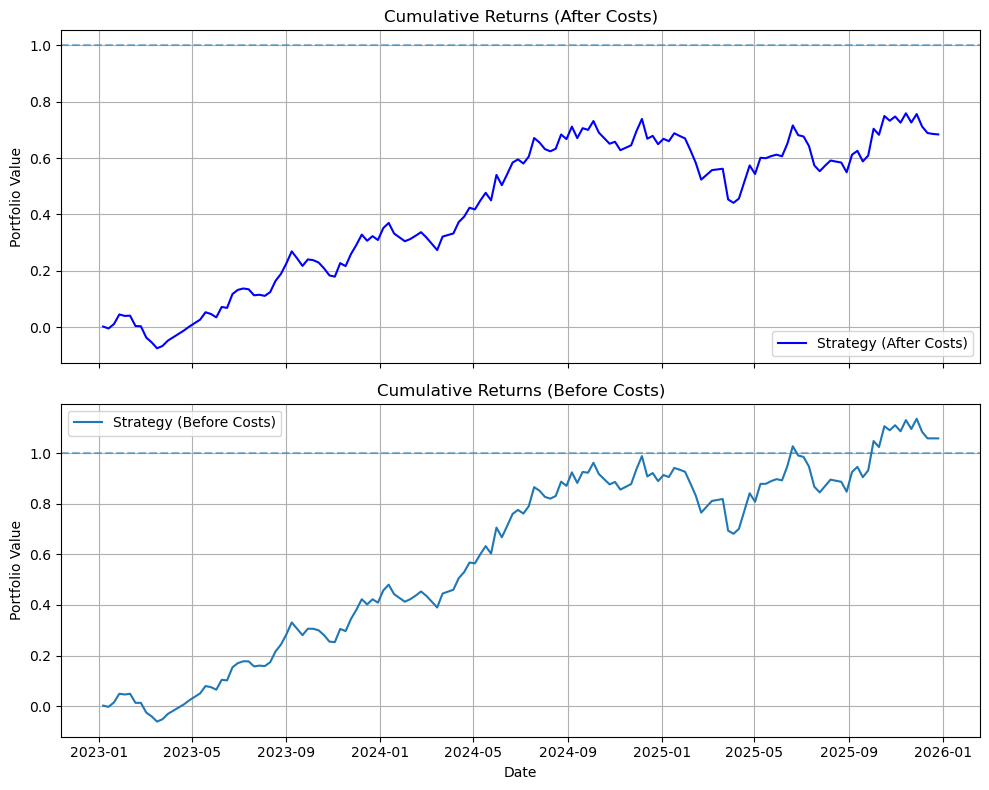

In [131]:
import matplotlib.pyplot as plt

cum_return_plot = cum_return.loc["2023-01-01":"2025-12-31"]
cum_return_0_plot = cum_return_0.loc["2023-01-01":"2025-12-31"]

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)


axes[0].plot(cum_return_plot,color='blue', label="Strategy (After Costs)")
axes[0].axhline(1, linestyle="--", alpha=0.5)
axes[0].set_title("Cumulative Returns (After Costs)")
axes[0].set_ylabel("Portfolio Value")
axes[0].legend()
axes[0].grid(True)


axes[1].plot(cum_return_0_plot, label="Strategy (Before Costs)")
axes[1].axhline(1, linestyle="--", alpha=0.5)
axes[1].set_title("Cumulative Returns (Before Costs)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Portfolio Value")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("equity_curve_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


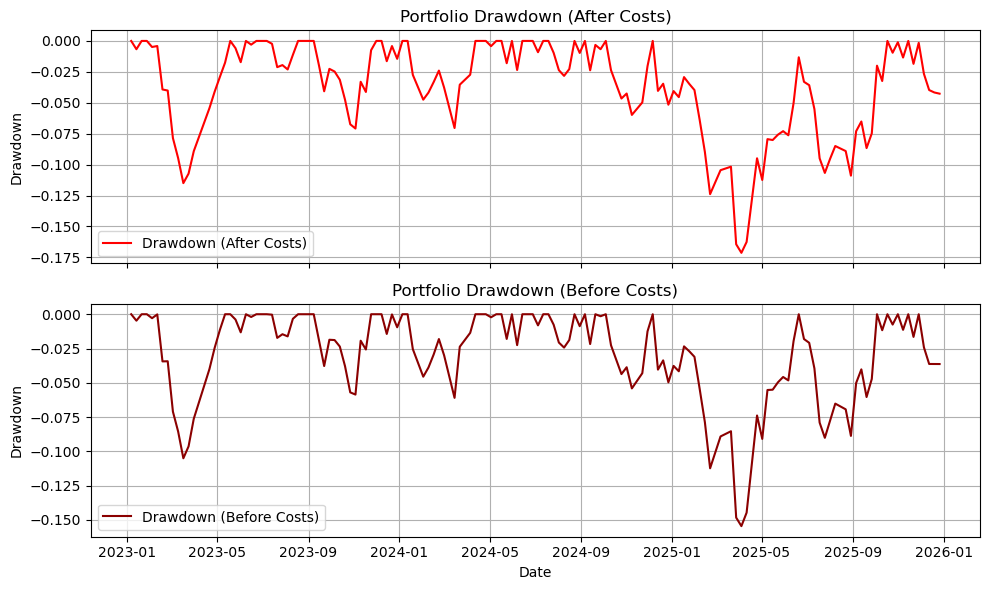

In [132]:
drawdown_plot = drawdown.loc["2023-01-01":"2025-12-31"]
drawdown_0_plot = drawdown_0.loc["2023-01-01":"2025-12-31"]
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(drawdown_plot, color="red", label="Drawdown (After Costs)")
axes[0].set_title("Portfolio Drawdown (After Costs)")
axes[0].set_ylabel("Drawdown")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(drawdown_0_plot, color="darkred", label="Drawdown (Before Costs)")
axes[1].set_title("Portfolio Drawdown (Before Costs)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Drawdown")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("drawdown_curve_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


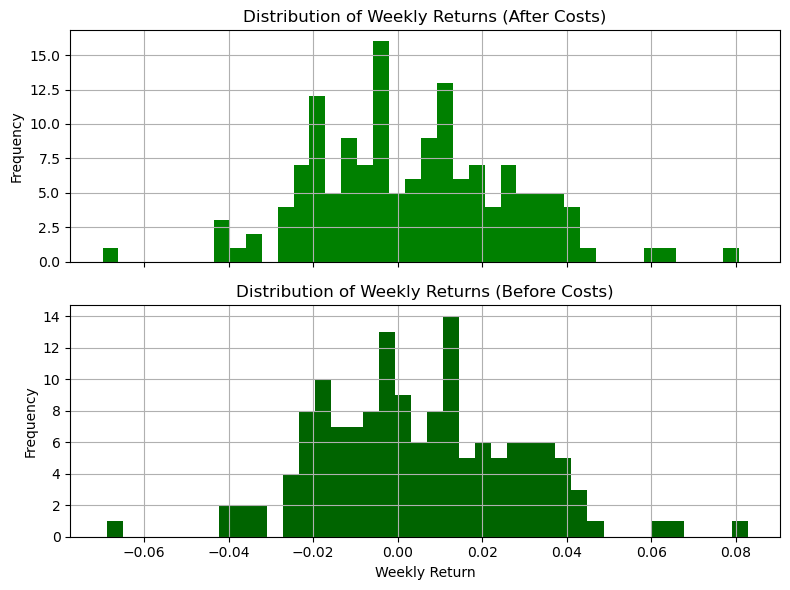

In [134]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axes[0].hist( portfolio_weekly_return_net.loc["2023-01-01":"2025-12-31"],color='green', bins=40)
axes[0].set_title("Distribution of Weekly Returns (After Costs)")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)

axes[1].hist( portfolio_weekly_return.loc["2023-01-01":"2025-12-31"],color='darkgreen', bins=40)
axes[1].set_title("Distribution of Weekly Returns (Before Costs)")
axes[1].set_xlabel("Weekly Return")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)

plt.tight_layout()
plt.show()



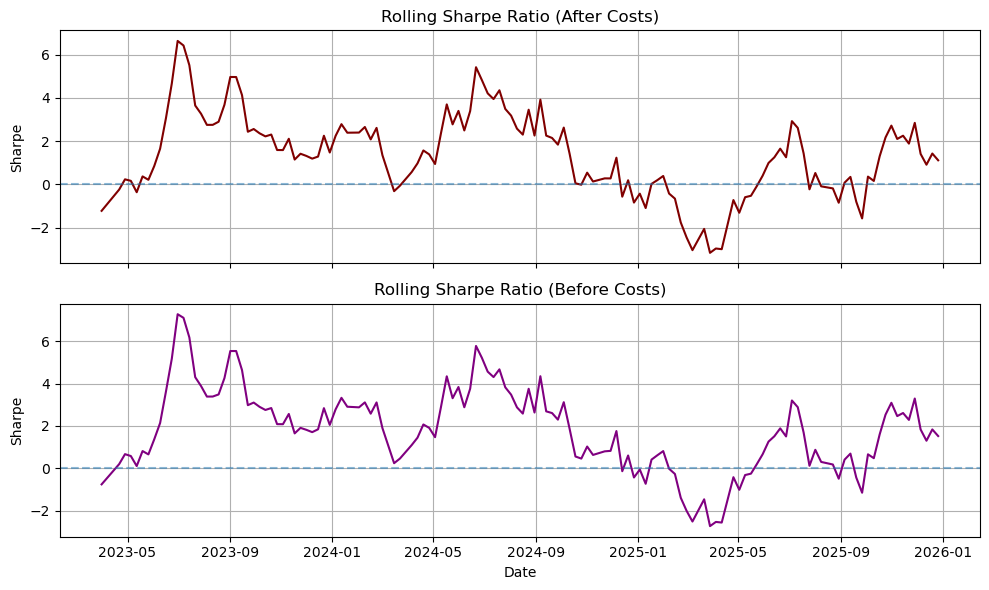

In [135]:
window = 13

rolling_sharpe_net =  portfolio_weekly_return_net.loc["2023-01-01":"2025-12-31"].rolling(window).apply(
    lambda x: (x.mean() / x.std()) * np.sqrt(52), raw=False
)

rolling_sharpe_0 = portfolio_weekly_return.loc["2023-01-01":"2025-12-31"].rolling(window).apply(
    lambda x: (x.mean() / x.std()) * np.sqrt(52), raw=False
)

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(rolling_sharpe_net,color='maroon')
axes[0].axhline(0, linestyle="--", alpha=0.5)
axes[0].set_title("Rolling Sharpe Ratio (After Costs)")
axes[0].set_ylabel("Sharpe")
axes[0].grid(True)

axes[1].plot(rolling_sharpe_0,color='purple')
axes[1].axhline(0, linestyle="--", alpha=0.5)
axes[1].set_title("Rolling Sharpe Ratio (Before Costs)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Sharpe")
axes[1].grid(True)

plt.tight_layout()
plt.show()


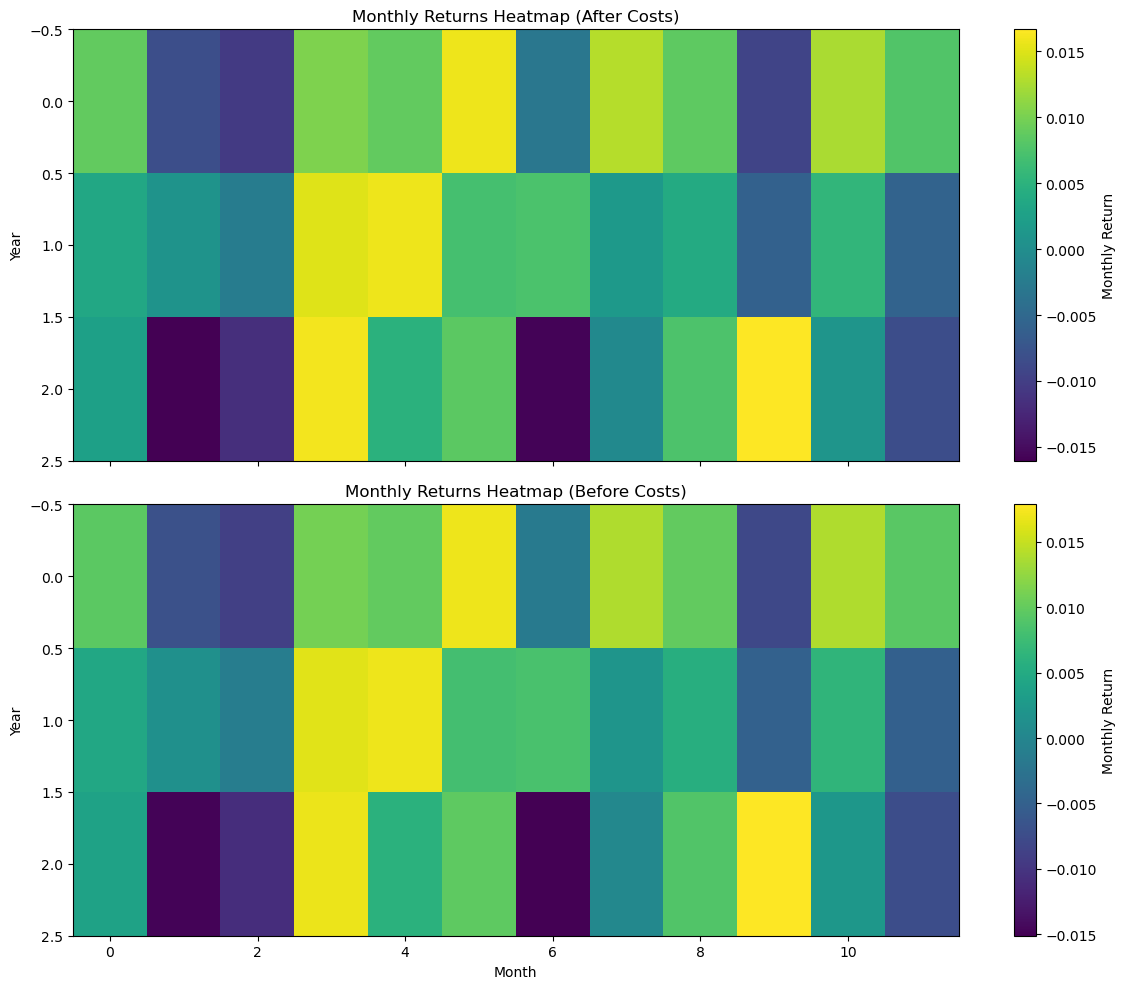

In [136]:
daily_ret_net = (1 +  portfolio_weekly_return_net.loc["2023-01-01":"2025-12-31"])**(1/5) - 1
daily_ret_net = daily_ret_net.dropna()
monthly_ret_net = daily_ret_net.resample("ME").apply(lambda x: (1 + x).prod() - 1)

df_net = monthly_ret_net.to_frame("ret")
df_net["Year"] = df_net.index.year
df_net["Month"] = df_net.index.month
pivot_net = df_net.pivot(index="Year", columns="Month", values="ret")

daily_ret_0 = (1 + portfolio_weekly_return.loc["2023-01-01":"2025-12-31"])**(1/5) - 1
daily_ret_0 = daily_ret_0.dropna()
monthly_ret_0 = daily_ret_0.resample("ME").apply(lambda x: (1 + x).prod() - 1)

df_0 = monthly_ret_0.to_frame("ret")
df_0["Year"] = df_0.index.year
df_0["Month"] = df_0.index.month
pivot_0 = df_0.pivot(index="Year", columns="Month", values="ret")

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

im1 = axes[0].imshow(pivot_net, aspect="auto")
axes[0].set_title("Monthly Returns Heatmap (After Costs)")
axes[0].set_ylabel("Year")
plt.colorbar(im1, ax=axes[0], label="Monthly Return")

im2 = axes[1].imshow(pivot_0, aspect="auto")
axes[1].set_title("Monthly Returns Heatmap (Before Costs)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Year")
plt.colorbar(im2, ax=axes[1], label="Monthly Return")

plt.tight_layout()
plt.show()


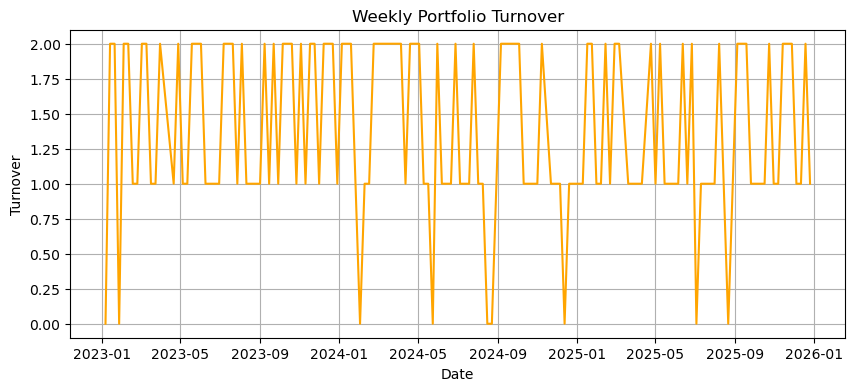

In [137]:
plt.figure(figsize=(10, 4))
plt.plot(turnover.loc["2023-01-01":"2025-12-31"],color='orange')
plt.title("Weekly Portfolio Turnover")
plt.xlabel("Date")
plt.ylabel("Turnover")
plt.grid(True)
plt.show()
